In [19]:
# Code By adityatb at https://github.com/adityatb/noise-reduction-using-rnn
# LSTM method test.
# Maintain by ShYy, 2018.
import tensorflow as tf
import scipy
import scipy.signal as signal
import numpy as np
import os, random, sys
import scipy.io.wavfile as wav
import math
import pandas as pd
import matplotlib.pyplot as plt 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
cd /content/gdrive/My Drive/Data/

/content/gdrive/My Drive/Data


In [22]:
os.getcwd()

'/content/gdrive/My Drive/Data'

## 함수정의부

In [23]:
#filename을 입력받아 앞에서부터 len(filename)-11 까지만 남긴 뒤 _voice 추가
def formatFilename(filename):
    return filename[:len(filename) - 11] + "_voice.wav"

# Strip away the _xnoise.wav part of the filename, and append _voice.wav to obtain clean voice counterpart

def create_final_sequence(sequence, max_length):
    a, b = sequence.shape
    extra_len = max_length - b
    null_mat = np.zeros((len(sequence), extra_len), dtype=np.float32)
    sequence = np.concatenate((sequence, null_mat), axis=1)
    return sequence


def sequentialized_spectrum(batch):   #여기서 batch는 데이터가 들어있는 repository를 의미한다.
    # Get maximum length of batch
    t = []
    t_vec = []
    Sxx_Vec = []
    for each in batch:
        _, t, Sxx_Vec_Temp = signal.stft(each, fs=rate_repository[0], nperseg=stft_size, return_onesided = False) #signal module의 stft사용후 frequency, time, Zxx가 생성됨
        t_vec.append(t)
        Sxx_Vec.append(Sxx_Vec_Temp)
    maximum_length = findMaxlen(t_vec)

    max_run_total = int(math.ceil(float(maximum_length) / sequence_length))
    final_data = np.zeros([len(batch), max_run_total, stft_size, sequence_length])
    true_time = np.zeros([len(batch), max_run_total])

    # Read in a file and compute spectrum
    # for batch_idx, each_set in enumerate(batch):
    for batch_idx, Sxx in enumerate(Sxx_Vec):
        # f, t, Sxx = signal.stft(each_set, fs=rate_repository[0], nperseg=stft_size, return_onesided = False)

        # Magnitude and Phase Spectra
        Mag = Sxx.real
        t = t_vec[batch_idx]
        # Phase = Sxx.imag

        # Break up the spectrum in sequence_length sized data
        run_full_steps = float(len(t)) / sequence_length  #3.1
        run_total = int(math.ceil(run_full_steps))      #4

        # Run a loop long enough to break up all the data in the file into chunks of sequence_size
        for step in range(2): #100의자리 한번 10의 자리에서 한번, 총두번 실행

            begin_point = step * sequence_length
            end_point = begin_point + sequence_length

            m, n = Mag[:, begin_point:end_point].shape

            # Store each chunk sequentially in a new array, accounting for zero padding when close to the end of the file
            if n == (sequence_length*(math.floor(run_full_steps))):
                final_data[batch_idx, step, :, :] = np.copy(Mag[:, begin_point:end_point])
                true_time[batch_idx, step] = n
            else:
                final_data[batch_idx, step, :, :] = np.copy(create_final_sequence(Mag[:, begin_point:end_point], sequence_length))
                true_time[batch_idx, step] = n

    final_data = np.transpose(final_data, (0, 1, 3, 2))

    return final_data, true_time, maximum_length

def findMaxlen(data_vec):
    max_ = 0
    for each in data_vec:
        if len(each) > max_:
            max_ = len(each)
    return max_

In [24]:
def sequentialized_spectrum(batch):   #여기서 batch는 데이터가 들어있는 repository를 의미한다.
    # Get maximum length of batch
    t = []
    t_vec = []
    Sxx_Vec = []
    for each in batch:
        _, t, Sxx_Vec_Temp = signal.stft(each, fs=rate_repository[0], nperseg=stft_size, return_onesided = False) #signal module의 stft사용후 frequency, time, Zxx가 생성됨
        t_vec.append(t)
        Sxx_Vec.append(Sxx_Vec_Temp)
    
    maximum_length = findMaxlen(t_vec)
    max_run_total = int(math.ceil(float(maximum_length) / sequence_length))  #trainig data중 최대의 길이를 100으로 나눈 값
    #final_data = np.zeros([len(batch), max_run_total, stft_size, sequence_length])
    #true_time = np.zeros([len(batch), max_run_total])
    
    #모든길이를 400으로 고정
    #true_time은 어떻게 해줘야하나... 각 시간 정보만 넣으면 되므로? 1로 설정(일단)
    final_data = np.zeros([len(file_repository), stft_size, max_run_total*sequence_length])
    true_time = np.zeros([len(file_repository), 1])

    # Read in a file and compute spectrum
    # for batch_idx, each_set in enumerate(batch):
    for batch_idx, Sxx in enumerate(Sxx_Vec):

        # Magnitude and Phase Spectra
        Mag = Sxx.real
        t = t_vec[batch_idx]  #왜 굳이? 옮기는건지는 모르겠음 아무튼 t와 t_vec은 동일
        # Phase = Sxx.imag

        # Break up the spectrum in sequence_length sized data
        #해당 인덱스에 해당하는 Audio의 길이 = run_full_step 즉 total time step 이라고 생각하면댐
        run_full_steps = float(len(t)) / sequence_length #311/100 = 3.11 -> 4 
        run_total = int(math.ceil(run_full_steps))  #ceil 올림함수
        run_floor = int(math.floor(run_full_steps))

        #final_data[batch_idx,:,:] = np.copy(create_final_sequence(Mag, run_total*sequence_length))
        final_data[batch_idx,:,:] = np.copy(create_final_sequence(Mag, 400))
        true_time[batch_idx] = 400

    final_data = np.transpose(final_data, (0, 2, 1))

    return final_data, true_time, maximum_length

## modeling에 필요한 변수들 선언

In [25]:
# ----------------- Begin Vars --------------------- #

# Training data directories
traindata = os.getcwd() + "/Training/NoiseAdded3/"
voicedata = os.getcwd() + "/Training/HumanVoices/"
checkpoints = os.getcwd() + "/TF_Checkpoints/"
modelOutput = os.getcwd() + "/Testing/ModelOutput5"
# NormConstant
norm_factor = (1 / 32768.0)

# Spectrogram Parameters
stft_size = 1024

# RNN Specs
sequence_length = 100
batch_size = 100
learning_rate = 0.001
epochs = 250
# number_of_layers = 3

# Tensorflow vars + Graph and LSTM Params --------------------------------------------------------------- tf 1.0 model 생성 시작 -----------------------------------------------------


# Temp_data_variables
no_of_files = 0
temp_list = []
final_data = []
sequence_length_id = 0

# Repositories
file_repository = []
rate_repository = []
clean_repository = []

# Selected vectors
files_vec = []
clean_files_fin_vec = []
clean_files_vec = []


# training Data 들을 읽어와서 list에 저장 

In [26]:
# ------------------- Read all data to memory creating a repository of mixture and clean files --------------------- #
#필요한 것, input 값들(noiseadded, humanvoice)
os.chdir(traindata)
# for file_iter in range(traindata):

# Buffer training data to memory for faster execution:
for root, _, files in os.walk(traindata):
    files = sorted(files)
    no_of_files = len(files)
    
    #files는 NoiseAdded data들을 의미하며 배치사이즈가 training data size보다 크면 말이 안되니까 여기서 에러처리
    if batch_size > no_of_files:
        sys.exit("Error: batch_size cannot be more than number of files in the training directory")

    #files를 읽어와 data와 samplingrate를 각각 리스트에 저장
    for f in files:
        if f.endswith(".wav"):
            temp_list.append(f)
            srate, data = wav.read(os.path.join(root, f))
            file_repository.append(data)
            rate_repository.append(srate)

In [27]:
# Generate a vector of file names that are clean files
#map은 (함수,인자) 를 입력으로 받고 들어온 모든 인자에 대해 함수를 실행시켜 리스트형태로 반환시켜주는 함수이다 고로 들어온 temp_list 인자들에 대해 formatFilename이 실행된다
#간단히 말하면 기존의 이름을 바꾸는 역할을 한다
clean_files_vec = list(map(formatFilename, temp_list))

#clean한 목소리 데이터들을 clean_repasitory에 저장
for root, _, files in os.walk(voicedata):
    files = sorted(files)
    for each in files:  #each 는 file하나하나 총 2000
        if each.endswith(".wav"): #each가 .wav로 끝난다면
            for name in clean_files_vec:  #clean_files_vec 에있는 
                if each == name:
                    srate2, data2 = wav.read(os.path.join(root, name))
                    clean_repository.append(data2)


file_repository : training data들이 저장되어있음

rate_repository : sampling rate들이 저장되어있음 (모두 16000 으로 동일한값)

clean_repository : noise가 없는 사람목소리 model fitting시 label 로쓰임

## sequentialized_spectrum 함수를 이용 푸리에 트랜스폼 실행

In [28]:
#모든 배열의 원소에 norm_factor를 곱한다. sequentialized_spectrum함수를
for file_iter in range(len(file_repository)):
    i = random.randint(0, len(file_repository) - 1)
    files_vec.append(file_repository[i] * norm_factor)
    clean_files_fin_vec.append(clean_repository[i] * norm_factor)

In [29]:
    #stft_bach, clean_voice_batch를 생성
    stft_batch, sequence_length_id, maximum_length = sequentialized_spectrum(files_vec)

In [ ]:
    clean_voice_batch, sequence_length_id_clean, maximum_length_clean = sequentialized_spectrum(clean_files_fin_vec)

In [ ]:
#용량이너무 커서 실패
#np.save('/content/gdrive/My Drive/Data/Testing/npArray_data/stft_batch', stft_batch)
#np.save('/content/gdrive/My Drive/Data/Testing/npArray_data/clean_voice_batch', clean_voice_batch)
#np.save('/content/gdrive/My Drive/Data/Testing/npArray_data/sequence_leng_id_clean', sequence_length_id_clean)
#np.save('/content/gdrive/My Drive/Data/Testing/npArray_data/maximum_length_clean', maximum_length_clean)
#np.save('/content/gdrive/My Drive/Data/Testing/npArray_data/maximum_length', maximum_length)

In [ ]:
#load 시 이를 사용
#loaded_x = np.load('./saved_x.npy')

In [ ]:
print(len(file_repository))
print(len(clean_repository))

## 트레이닝셋과 테스트셋 만들기

stft_batch 는 x_data로, 

clean_voice_batch 는 y_data로 사용

In [ ]:
X_train = stft_batch
Y_train = clean_voice_batch

# 모델형성

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras import layers
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
#Model 생성, 층추가

model = Sequential() # Sequeatial Model
model.add(layers.LSTM(512, input_shape=(400, 1024),return_sequences=True)) # (timestep, feature)
model.add(layers.Dense(1024))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
#model 폴더생성
model_path = '/content/gdrive/My Drive/Data/Testing/model4/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

#Validation점수가 좋아지지않으면 중지
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

#Vailidation 점수가 가장 좋은 모델만 저장
model_file_path = model_path + 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True,)

In [20]:
os.getcwd()

'/content/gdrive/My Drive/Data/Training/NoiseAdded3'

In [21]:
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
"""
model.fit(mini_x_data, mini_y_data, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])
"""
EPOCH = 100
BATCH_SIZE = 20
filename = model_path + '/checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)

history = model.fit(X_train, Y_train,
      epochs=EPOCH, 
      batch_size= BATCH_SIZE,
      validation_split = 0.1,
      shuffle = True,
      callbacks=[checkpoint, early_stopping], # checkpoint 콜백
     )

Epoch 1/100
90/90 [==============================] - ETA: 0s - loss: 1.7519e-05
Epoch 00001: val_loss improved from inf to 0.00002, saving model to /content/gdrive/My Drive/Data/Testing/model4/Epoch_001_Val_0.000.hdf5
90/90 [==============================] - 95s 1s/step - loss: 1.7519e-05 - val_loss: 1.7798e-05
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 1.6878e-05
Epoch 00002: val_loss improved from 0.00002 to 0.00002, saving model to /content/gdrive/My Drive/Data/Testing/model4/Epoch_002_Val_0.000.hdf5
90/90 [==============================] - 100s 1s/step - loss: 1.6878e-05 - val_loss: 1.7046e-05
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 1.6227e-05
Epoch 00003: val_loss improved from 0.00002 to 0.00002, saving model to /content/gdrive/My Drive/Data/Testing/model4/Epoch_003_Val_0.000.hdf5
90/90 [==============================] - 97s 1s/step - loss: 1.6227e-05 - val_loss: 1.6359e-05
Epoch 4/100
90/90 [==============================] -

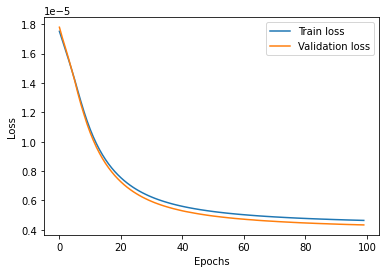

In [22]:
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

왜 validation loss가 더 적지..?

mini_x_data로 학습한 이유

RNN 모델의 input shape는 (100,1024) 이다.
그러나 stft_batch는 (2000,4,100,1024) 이기 때문에
mini_x_data = stft_batch[:,0,:,:] 으로 중간의 2번에 축의 데이터를 하나만 사용하였다.

In [ ]:
maxTimeSteps = 4

In [ ]:
#model.output 출력부분

Keras로 바꾼 부분은 여기까지

model.predict로 최종 결과물 까지 확인해보고 싶으나
역변환이 제대로 되지않는것을 확인해 아직 구현하지 않음
추후 수정해야할 부분

# 원본을 그대로 복구해보기(inverse stft)
stft_batch는 원본 데이터들을 stft시켜놓은 파일이다
이를 다른 과정을 거치지 않고 바로 역변환 시켜 보자.
training data중 3개의 sample로 진행

수정된 부분 : sess.run([final_state, rnn_outputs], feed_dict=feed_dict) -> stft_batch[idx][timestep]

외 추가적으로 오류난 부분을 수정함

목적 : 역변환 code가 정상적으로 돌아가는지 확인

In [ ]:
#(2000,400,1024) 로 출력될거라 예상

In [ ]:
# Start Processing
for idx in range(3):

    outputData = np.zeros([1,stft_size, sequence_length])           # Transpose, [0, 1, 3, 2]
    #(1,1024,400)
    #변환이 안되는 이유!
    for timeStep in range(maxTimeSteps):
        rnn_outputs_value = stft_batch[idx][timeStep]
        rnn_outputs_value = np.expand_dims(rnn_outputs_value, axis = 0)           #오류가 예상되는 부분
        rnn_outputs_value = np.transpose(rnn_outputs_value, [0, 2, 1])
        outputData[0][timeStep] = rnn_outputs_value

    # Define outputData_STFT, link outputData List by timeStep in 1 dimension.-----------------------------------------------------------------------------
    outputData_STFT = np.zeros([stft_size, maximum_length])
    beginTime = 0
    endTime = 0

    for timeStep in range(maxTimeSteps):
        if(timeStep < maxTimeSteps - 1):
            endTime = beginTime + sequence_length
            outputData_STFT[:, beginTime : endTime] = outputData[0, timeStep, :, :]
        else:
            endTime = beginTime + int(sequence_length_id[0, timeStep])
            outputData_STFT[:, beginTime : endTime] = outputData[0, timeStep, :, 0 : (endTime - beginTime)]

        beginTime = beginTime + sequence_length

    # Compute ISTFT
    _, outputData_ISTFT = signal.istft(outputData_STFT, fs=16000, nperseg=stft_size, input_onesided = False)

    outputData_ISTFT = (outputData_ISTFT / norm_factor).real
    outputData_ISTFT = outputData_ISTFT.astype(np.int16)

    wav.write(modelOutput +'/file_'+ str(idx) +".wav", 16000 , outputData_ISTFT)
    print("Index: " + str(idx))

# 함수 도중에 쓰인 값을의 shape 확인
이를 토대로 model.predict값을 어떻게 적용시킬지 고민해보자

In [ ]:
#원본파일파형
stft_batch[1][1].shape

In [23]:
#복구파일파형
outputData_STFT.shape

NameError: ignored

In [ ]:
rnn_outputs_value = stft_batch[0][1]
print(rnn_outputs_value)
print(rnn_outputs_value.shape)

In [ ]:
rnn_outputs_value1 = np.expand_dims(rnn_outputs_value, axis = 0)           #오류가 예상되는 부분
print(rnn_outputs_value1)
print(rnn_outputs_value1.shape)

In [ ]:
rnn_outputs_value2 = np.transpose(rnn_outputs_value1, [0, 2, 1])
print(rnn_outputs_value2)
print(rnn_outputs_value2.shape)

In [ ]:
outputData[0][timeStep] = rnn_outputs_value2
print(outputData)
print(outputData.shape)

# Model을 적용시켜보기

In [ ]:
modeloutput = model.predict(X_train)

In [ ]:
modeloutput.shape
#(2000,1024,400)

In [ ]:
#transpose(0,2,1)
#istft 실행
#Audio file 추출

In [ ]:
modeloutput1 = np.expand_dims(modeloutput, axis = 1)
modeloutput1.shape

In [ ]:
modeloutput2 = np.append(modeloutput1, modeloutput1[:,:,:,:], axis=1)
modeloutput2.shape

In [ ]:
# Start Processing
for idx in range(3):

    outputData = np.zeros([1, stft_size, sequence_length])           # Transpose, [0, 1, 3, 2]

    #변환이 안되는 이유!
    for timeStep in range(maxTimeSteps):
      #뭘 뺴오는 거지??
        rnn_outputs_value = modeloutput2[idx]
        rnn_outputs_value = np.expand_dims(rnn_outputs_value, axis = 0)           #오류가 예상되는 부분
        rnn_outputs_value = np.transpose(rnn_outputs_value, [0, 2, 1])
        outputData[0] = rnn_outputs_value

  """
    # Define outputData_STFT, link outputData List by timeStep in 1 dimension.-----------------------------------------------------------------------------
    outputData_STFT = np.zeros([stft_size, maximum_length])
    beginTime = 0
    endTime = 0

    for timeStep in range(maxTimeSteps):
        if(timeStep < maxTimeSteps - 1):
            endTime = beginTime + sequence_length
            outputData_STFT[:, beginTime : endTime] = outputData[0, timeStep, :, :]
        else:
            endTime = beginTime + int(sequence_length_id[0, timeStep])
            outputData_STFT[:, beginTime : endTime] = outputData[0, timeStep, :, 0 : (endTime - beginTime)]

        beginTime = beginTime + sequence_length
  """

    # Compute ISTFT
    _, outputData_ISTFT = signal.istft(outputData[idx], fs=16000, nperseg=stft_size, input_onesided = False)

    outputData_ISTFT = (outputData_ISTFT / norm_factor).real
    outputData_ISTFT = outputData_ISTFT.astype(np.int16)

    wav.write(modelOutput +'/file_output'+ str(idx) +".wav", 16000 , outputData_ISTFT)
    print("Index: " + str(idx))

In [ ]:
file_repository[0].shape

In [ ]:
    wav.write(modelOutput +'/file_original_'+ str(0) +".wav", 16000 , file_repository[0])
    wav.write(modelOutput +'/file_original_'+ str(1) +".wav", 16000 , file_repository[1])
    wav.write(modelOutput +'/file_original_'+ str(2) +".wav", 16000 , file_repository[2])        

In [ ]:
_, t, Sxx_Vec_Temp = signal.stft(file_repository[0], fs=rate_repository[0], nperseg=stft_size, return_onesided = False) #signal module의 stft사용후 frequency, time, Zxx가 생성됨

In [ ]:
print(file_repository[0].shape)
print(_.shape)
print(t.shape)
print(Sxx_Vec_Temp.shape)


In [ ]:
#stft_size 란?
#311은 뭘 의미하는거지?

In [ ]:
print(t)
plt.plot(Sxx_Vec_Temp)
plt.show()